## Convolutional Network in TensorFlow
It's time to walk through an example Convolutional Neural Network (CNN) in TensorFlow.

The structure of this network follows the classic structure of CNNs, which is a mix of convolutional layers and max pooling, followed by fully-connected layers.

In [35]:
import time
import pylab as pl
from IPython import display
%matplotlib inline

from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("./datasets/mnist", one_hot=True, reshape=False)

import tensorflow as tf

# Parameters
learning_rate = 0.00001
epochs = 4
batch_size = 256

# Number of samples to calculate validation and accuracy
# Decrease this if you're running out of memory to calculate accuracy
test_valid_size = 256

# Network Parameters
n_classes = 10  # MNIST total classes (0-9 digits)
dropout = 0.75  # Dropout, probability to keep units

Extracting ./datasets/mnist/train-images-idx3-ubyte.gz
Extracting ./datasets/mnist/train-labels-idx1-ubyte.gz
Extracting ./datasets/mnist/t10k-images-idx3-ubyte.gz
Extracting ./datasets/mnist/t10k-labels-idx1-ubyte.gz


In [36]:
# Store layers weight & bias
weights = {
    'wc1': tf.Variable(tf.random_normal([5, 5, 1, 32])),
    'wc2': tf.Variable(tf.random_normal([5, 5, 32, 64])),
    'wd1': tf.Variable(tf.random_normal([7*7*64, 1024])),
    'out': tf.Variable(tf.random_normal([1024, n_classes]))}

biases = {
    'bc1': tf.Variable(tf.random_normal([32])),
    'bc2': tf.Variable(tf.random_normal([64])),
    'bd1': tf.Variable(tf.random_normal([1024])),
    'out': tf.Variable(tf.random_normal([n_classes]))}

The <code>tf.nn.conv2d()</code> function computes the convolution against weight W as shown above.

In TensorFlow, _strides_ is an array of 4 elements; the first element in this array indicates the stride for batch and last element indicates stride for features. It's good practice to remove the batches or features you want to skip from the data set rather than use a stride to skip them. You can always set the first and last element to 1 in strides in order to use all batches and features.

The middle two elements are the strides for height and width respectively. You usually have a square stride where height = width. When someone says they are using a stride of 3, they usually mean <code>tf.nn.conv2d(x, W, strides=[1, 3, 3, 1])</code>.

Rectified Linear Unit (RELU) used here is $f(x)=ln(1+e^{x})$

In [37]:
def conv2d(x, W, b, strides=1):
    x = tf.nn.conv2d(x, W, strides=[1, strides, strides, 1], padding='SAME')
    x = tf.nn.bias_add(x, b)
    return tf.nn.relu(x)

def maxpool2d(x, k=2):
    return tf.nn.max_pool(x, ksize=[1, k, k, 1], strides=[1, k, k, 1], padding='SAME')

def conv_net(x, weights, biases, dropout):
    # Layer 1 - 28*28*1 to 14*14*32
    conv1 = conv2d(x, weights['wc1'], biases['bc1'])
    conv1 = maxpool2d(conv1, k=2)

    # Layer 2 - 14*14*32 to 7*7*64
    conv2 = conv2d(conv1, weights['wc2'], biases['bc2'])
    conv2 = maxpool2d(conv2, k=2)

    # Fully connected layer - 7*7*64 to 1024
    fc1 = tf.reshape(conv2, [-1, weights['wd1'].get_shape().as_list()[0]])
    fc1 = tf.add(tf.matmul(fc1, weights['wd1']), biases['bd1'])
    fc1 = tf.nn.relu(fc1)
    fc1 = tf.nn.dropout(fc1, dropout)

    # Output Layer - class prediction - 1024 to 10
    out = tf.add(tf.matmul(fc1, weights['out']), biases['out'])
    return out

In [38]:
# tf Graph input
x = tf.placeholder(tf.float32, [None, 28, 28, 1])
y = tf.placeholder(tf.float32, [None, n_classes])
keep_prob = tf.placeholder(tf.float32)

# Model
logits = conv_net(x, weights, biases, keep_prob)

# Define loss and optimizer
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=y))
optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate).minimize(cost)

# Accuracy
correct_pred = tf.equal(tf.argmax(logits, 1), tf.argmax(y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

# Initializing the variables
init = tf.global_variables_initializer()
_times = 0
times, losses, accs = [], [], []

In [39]:
def plot_loss_and_accuracy(times, loss, accuracy):
    pl.ylim(min(min(loss), min(accuracy)) , max(max(loss),max(accuracy)))
    pl.xlim(min(times), max(times))
    
    pl.plot(times, loss, label = 'Training Loss', color = 'red')
    pl.plot(times, accuracy, label = 'Validation Accuracy', color = 'green')
    pl.legend(loc='upper right')
    pl.xlabel('Time')

    display.clear_output(wait=True)
    display.display(pl.gcf())
    pl.gcf().clear()
    time.sleep(0.1)

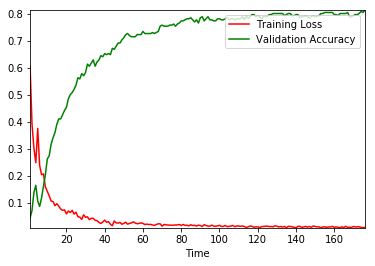

Epoch  4, Batch 211 - Loss:     0.0081 Validation Accuracy: 0.8125
Testing Accuracy: 0.78125


In [41]:
# Launch the graph
with tf.Session() as sess:
    sess.run(init)

    for epoch in range(epochs):
        for batch in range(mnist.train.num_examples//batch_size):
            batch_x, batch_y = mnist.train.next_batch(batch_size)
            sess.run(optimizer, feed_dict={x: batch_x, y: batch_y, keep_prob: dropout})

            # Calculate batch loss and accuracy
            loss = sess.run(cost, feed_dict={x: batch_x, y: batch_y, keep_prob: 1.})
            valid_acc = sess.run(accuracy, feed_dict={
                x: mnist.validation.images[:test_valid_size],
                y: mnist.validation.labels[:test_valid_size],
                keep_prob: 1.})
            
            if batch % 5 == 0:
                _times += 1
                times.append(_times)
                losses.append(loss/100000)
                accs.append(valid_acc)
                plot_loss_and_accuracy(times, losses, accs)

                print('Epoch {:>2}, Batch {:>3} - Loss: {:>10.4f} Validation Accuracy: {:.4f}'.format(
                    epoch + 1,
                    batch + 1,
                    loss/100000,
                    valid_acc))
            
    # Calculate Test Accuracy
    test_acc = sess.run(accuracy, feed_dict={
        x: mnist.test.images[:test_valid_size],
        y: mnist.test.labels[:test_valid_size],
        keep_prob: 1.})
    print('Testing Accuracy: {}'.format(test_acc))